## Initialization Notebook

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers

np.random.seed(1024)

In [2]:
class Task:
    def __init__(self, x, y):
        self.name = "Task"
        self.x = x
        self.y = y
        self.reward = np.random.randint(0, 100)

    def __str__(self):
        return f"Task at ({self.x}, {self.y})"

    def __repr__(self):
        return f"Task at ({self.x}, {self.y}) with reward {self.reward}"
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
# Robot class with random position and speed initialization
class Robot:
    def __init__(self, grid_size):
        # Random x, y position within grid boundaries
        self.x = np.random.randint(0, grid_size[0])
        self.y = np.random.randint(0, grid_size[1])
        # Random speed between 0.5 and 1.0
        self.speed = np.random.uniform(0.5, 1.0)

    def __repr__(self):
        return f"Robot at ({self.x}, {self.y}) with speed {self.speed:.2f}"

In [3]:
def init_robots(num_robots, grid_size):
    robots = [Robot(grid_size) for _ in range(num_robots)]
    return robots

def init_tasks(num_tasks, grid_size):
    tasks = [Task(
        np.random.randint(0, grid_size[0]),  # random x position
        np.random.randint(0, grid_size[1]))  # random y position
        for _ in range(num_tasks)]
    return tasks

def get_rewards(tasks):
    return [task.reward for task in tasks]

def visualize(robots, tasks, grid_size):
    # TASKS VIS
    reward_grid = np.zeros(grid_size)
    for task in tasks:
        reward_grid[task.x, task.y] = task.reward

    mask = reward_grid == 0

    # Plot the heatmap for tasks with rewards
    plt.figure(figsize=(10, 8))
    sns.heatmap(reward_grid, mask=mask, annot=True, fmt=".0f", cmap="coolwarm", 
                linewidths=0.5, square=True, cbar_kws={"label": "Reward"}, 
                annot_kws={"color": "black"})
    
    # ROBOT VIS
    for robot in robots:
        plt.scatter(robot.y + 0.5, robot.x + 0.5, color='lime', s=200, marker='X', edgecolors='black', label="Robot")

    # To avoid clutter, ensure we only add the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(handles) == 0:
        plt.legend(["Robot"], loc='upper right')

    plt.title("Task Rewards Heatmap with Robot Positions")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

In [4]:
def create_robot_task_matrix(robots, tasks):
    r = len(robots)
    t = len(tasks)
    
    # Initialize the r x t x 2 matrix
    matrix = np.zeros((r, t, 2))
    
    for i, robot in enumerate(robots):
        for j, task in enumerate(tasks):
            # Calculate Euclidean distance
            distance = np.sqrt((robot.x - task.x)**2 + (robot.y - task.y)**2)
            
            # Populate the matrix with (speed, distance)
            matrix[i, j] = [robot.speed, distance]
    
    return matrix

robots = init_robots(5, (10, 10))
tasks = init_tasks(30, (10, 10))
# Example usage:
robot_task_matrix = create_robot_task_matrix(robots, tasks)
print(robot_task_matrix.shape)  # Should print (5, 30, 2) for 5 robots and 30 tasks
print(robot_task_matrix[0, 0])  # Example output for first robot and first task

(5, 30, 2)
[0.85142165 4.47213595]


In [5]:
def get_allocations(ExBids, ExCare):
# ExCare = [[5, 6, 7, 8]]


# ExBids = [[5, 6, 7, 8],
#           [2, 6, 3, 4],
#           [6, 4, 2, 3],
#           [8, 5, 1, 2]]

    output = [[0 for _ in range(len(ExBids[0]))] for _ in range(len(ExBids))]

    used_columns = set()

    # Run a for loop for the number of rows in ExBids
    for _ in range(len(ExBids)):
        while True:  # Repeat the loop until a valid max value is found
            max_value = -float('inf')  # Reset max value for each iteration
            max_row, max_col = 0, 0  # Reset indices for each iteration

            # Loop through the grid to find the maximum value and its indices
            for row in range(len(ExBids)):
                for col in range(len(ExBids[row])):
                    if ExBids[row][col] > max_value:
                        max_value = ExBids[row][col]
                        max_row, max_col = row, col

            # If this column has already been used for another max, invalidate and try again
            if max_col in used_columns:
                ExBids[max_row][max_col] = -float('inf')
                continue  # Retry to find another maximum value in a different column

            # Store this column as used
            used_columns.add(max_col)

            # Extract the column where the max value is located
            column_values = [ExBids[row][max_col] for row in range(len(ExBids))]

            # Remove the max value from the column and find the second highest value
            column_values.remove(max_value)
            second_highest_value = max(column_values)

            # Find the corresponding value from ExCare
            corresponding_care_value = ExCare[max_col]

            # Check if second_highest_value is -inf, if so, use max_value instead
            if second_highest_value == -float('inf'):
                difference = corresponding_care_value - max_value
            else:
                # Calculate the difference with second highest value
                difference = corresponding_care_value - second_highest_value

            # Store the difference at the (max_row, max_col) index of the output grid
            output[max_row][max_col] = difference

            # Modify the entire row of max_row in ExBids to -float('inf')
            ExBids[max_row] = [-float('inf')] * len(ExBids[max_row])

            # # Modify the corresponding ExCare index (max_col) to -float('inf')
            # ExCare[max_col] = -float('inf')

            # # Print the current state of ExBids, ExCare, and output after each iteration
            # print(f"After iteration {_ + 1}:")
            # print("Output grid:")
            # for row in output:
            #     print(row)

            # print("Modified ExBids grid:")
            # for row in ExBids:
            #     print(row)

            # print("Modified ExCare list:")
            # print(ExCare)
            # print("\n----------------------\n")

            break  # Exit the while loop after a valid max value is processed
    output_dict = {}
    for row_idx, row in enumerate(output):
        for col_idx, value in enumerate(row):
            if value != 0:
                output_dict[row_idx] = (col_idx, value)
                break  # Since only one non-zero value is expected per row

    # print("Output dictionary:")
    # print(output_dict)
    return output_dict

In [6]:
def get_bids(attributes, tasks, num_epochs=100):
    R, T, A = attributes.shape
    reward_vec = get_rewards(tasks)

    # initialize model
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(A,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    for _ in range(num_epochs):
        # get bids based on model
        bids = np.zeros((R, T))
        for r in range(R):
            for t in range(T):
                a_input = attributes[r, t].reshape(1, A) # added .reshape(1, A)
                # bids[r, t] = model.predict(a_input.reshape(1, -1), verbose=0)
                bids[r, t] = max(0, model.predict(a_input, verbose=0))

        # send bids to allocation function
        allocations = get_allocations(bids, reward_vec) # dictionary with keys 0...r-1 and values are tuples (task, utility)
        print(allocations)

        # update model based on those utilities
        for r in range(R):
            utility = allocations[r][1].reshape(1, 1)
            task = allocations[r][0]
            input = attributes[r, task].reshape(1, A)
            model.fit(input, utility, verbose=0)
    print(bids)
    return model, allocations



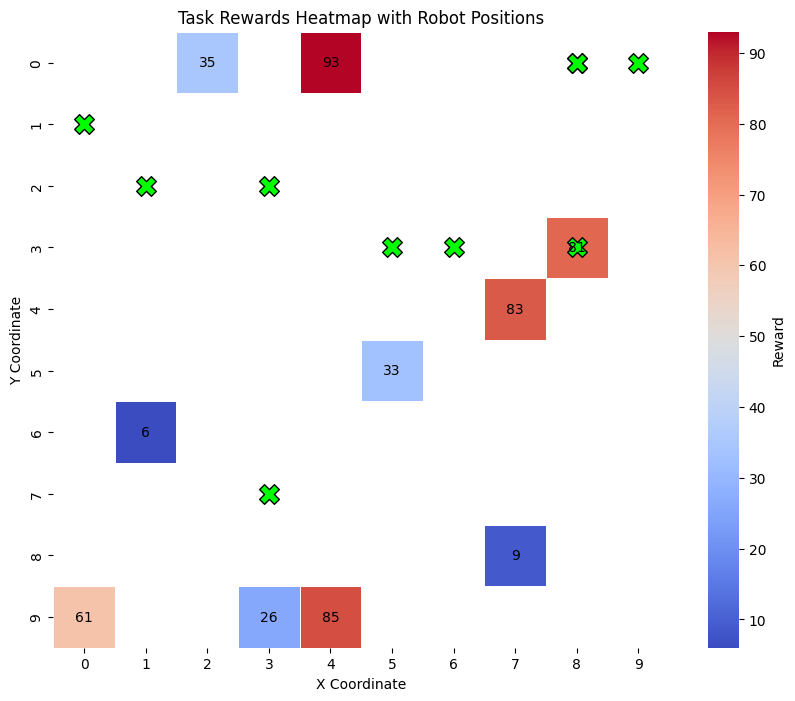

/Users/ojaskarnavat/miniconda3/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


{0: (9, 7.799173355102539), 1: (1, 92.56046944856644), 2: (8, 82.76724335551262), 3: (7, 59.30981731414795), 4: (0, 80.35427236557007), 5: (4, 24.585200309753418), 6: (2, 32.79748256504536), 7: (3, 34.507206201553345), 8: (5, 5.27886426448822), 9: (6, 83.93497395515442)}
{0: (9, 6.770495891571045), 1: (1, 92.08798670768738), 2: (8, 82.49279499053955), 3: (7, 57.866103410720825), 4: (0, 79.70795178413391), 5: (4, 23.34113049507141), 6: (2, 32.55167379975319), 7: (3, 33.967225193977356), 8: (5, 4.542030692100525), 9: (6, 83.00587904453278)}
{0: (9, 5.753117561340332), 1: (1, 91.61917495727539), 2: (8, 82.18318110704422), 3: (7, 56.436813831329346), 4: (0, 79.0654227733612), 5: (4, 22.106305360794067), 6: (2, 32.279304683208466), 7: (3, 33.41822600364685), 8: (5, 3.8113749027252197), 9: (6, 82.08555722236633)}
{0: (9, 4.781333923339844), 1: (1, 91.18589878082275), 2: (8, 81.87999081611633), 3: (7, 55.061381816864014), 4: (0, 78.46258854866028), 5: (4, 20.92261552810669), 6: (2, 31.9975019

In [7]:
grid_size = (10, 10)
num_robots = 10
num_tasks = 10

robots = init_robots(num_robots, grid_size)
tasks = init_tasks(num_tasks, grid_size)
visualize(robots, tasks, grid_size)

attributes = create_robot_task_matrix(robots, tasks)
model, allocations = get_bids(attributes, tasks)

print(allocations)

